First download the list 

In [1]:
import requests
import os

dir_path = os.getcwd()

lista_finale_post_script_csv = os.path.join(dir_path, "lista_finale_post_script.csv")
lista_finale_csv = os.path.join(dir_path, "lista_finale.csv")

# Construct the URL for exporting the sheet in CSV format
lista_finale_post_script_URL = "https://docs.google.com/spreadsheets/d/1G3WiRMoopP8Y2FlVJfwCRqZVLilw-aMQRBxF_SoMF20/export?format=csv&gid=2002066435"
lista_finale_url = "https://docs.google.com/spreadsheets/d/1G3WiRMoopP8Y2FlVJfwCRqZVLilw-aMQRBxF_SoMF20/export?format=csv&gid=92667368"


try:
  # Download the lista finale post script 3
  response = requests.get(lista_finale_post_script_URL)
  response.raise_for_status()
  with open(lista_finale_post_script_csv, "wb") as file:
    file.write(response.content)
  print(f"Lista finale downloaded successfully and saved")

  # Download the lista finale
  response = requests.get(lista_finale_url)
  response.raise_for_status()
  with open(lista_finale_csv, "wb") as file:
    file.write(response.content)
  print(f"Lista finale downloaded successfully and saved")

except requests.exceptions.RequestException as e:
  print(f"Error downloading the Google Sheet: {e}")

Lista finale downloaded successfully and saved
Lista finale downloaded successfully and saved


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

KEY_URL_PROGETTO = "URL progetto"
SITO_FUNZIONANTE = "Sito funzionante"
SITO_NON_TROVATO = "Sito non trovato"
SITO_NON_FUNZIONANTE = "Sito non funzionante"
SITO_NON_REINDERIZZATO = "Sito non reinderizzato"
SITO_PARZIALMENTE_INACCESSIBILE = "Sito parzialmente Inacessibile"

KEY_URL_PROGETTO_FIRST_SEEN = "URL progetto First_Seen"
KEY_URL_PROGETTO_LAST_SEEN = "URL progetto Last_Seen"

data = pd.read_csv(lista_finale_csv)
data_with_dates = pd.read_csv(lista_finale_post_script_csv)

# Add timestamp columns
for index, row in data.iterrows():
  url_progetto = row[KEY_URL_PROGETTO]
  if pd.notna(url_progetto):
    matching_rows = data_with_dates[data_with_dates[KEY_URL_PROGETTO] == url_progetto]
    if not matching_rows.empty:
      first_seen = matching_rows[KEY_URL_PROGETTO_FIRST_SEEN].min()
      last_seen = matching_rows[KEY_URL_PROGETTO_LAST_SEEN].max()
      data.at[index, KEY_URL_PROGETTO_FIRST_SEEN] = first_seen
      data.at[index, KEY_URL_PROGETTO_LAST_SEEN] = last_seen

print(f"Number of projects: {data.shape[0]}\n")
print(f"Number of projects with functioning website: {data[data[SITO_FUNZIONANTE] == True].shape[0]}")
print(f"Number of projects with partially inaccessible website: {data[data[SITO_PARZIALMENTE_INACCESSIBILE] == True].shape[0]}\n")
print(f"Number of projects with unavailable website: {data[data[SITO_NON_TROVATO] == True].shape[0]}")
print(f"Number of projects with non-functioning website: {data[data[SITO_NON_FUNZIONANTE] == True].shape[0]}")
print(f"Number of projects with non-redirected website: {data[data[SITO_NON_REINDERIZZATO] == True].shape[0]}")

dataset1 = os.path.join(dir_path, "dataset_1.csv")
data.to_csv(dataset1, index=False)
data.to_csv(os.path.join(os.pardir, "dataset_1.csv"), index=False)

print(f"Dataset saved")

Number of projects: 262

Number of projects with functioning website: 206
Number of projects with partially inaccessible website: 31

Number of projects with unavailable website: 20
Number of projects with non-functioning website: 26
Number of projects with non-redirected website: 11
Dataset saved


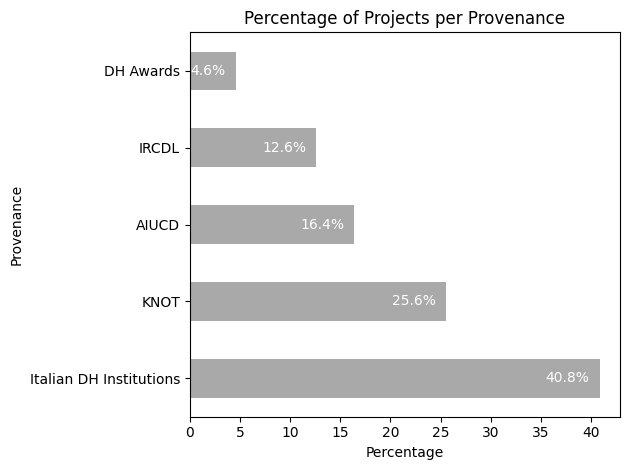

In [3]:
# Calculate the percentage of projects per provenance
provenance_counts = data['Provenance'].value_counts(normalize=True) * 100

# Plot the horizontal bar chart
fig, ax = plt.subplots()
bars = provenance_counts.plot(kind='barh', ax=ax, color='darkgrey')
ax.set_title('Percentage of Projects per Provenance')
ax.set_xlabel('Percentage')
ax.set_ylabel('Provenance')
plt.tight_layout()

for bar in bars.patches:
  ax.text(bar.get_width() - 1, bar.get_y() + bar.get_height() / 2,
      f'{bar.get_width():.1f}%', va='center', ha='right', color='white', fontsize=10)

plt.show()

In [4]:
unavailable_projects = data[(data[SITO_NON_TROVATO] == False) & (data[SITO_FUNZIONANTE] == False)]

print(f"Projects with unavailable website: {unavailable_projects.shape[0]}")

dataset2 = os.path.join(dir_path, "dataset_2.csv")

unavailable_projects.to_csv(dataset2, index=False, escapechar='\\', quoting=1)
unavailable_projects.to_csv(os.path.join(os.pardir, "dataset_2.csv"), index=False, escapechar='\\', quoting=1)
print(f"Dataset saved")


Projects with unavailable website: 36
Dataset saved


In [5]:
# Define the URL and file path for the new dataset
new_dataset_url = "https://docs.google.com/spreadsheets/d/1G3WiRMoopP8Y2FlVJfwCRqZVLilw-aMQRBxF_SoMF20/export?format=csv&gid=894427287"
new_dataset_csv = os.path.join(dir_path, "unavailable_projects.csv")

try:
  # Download the new dataset
  response = requests.get(new_dataset_url)
  response.raise_for_status()
  with open(new_dataset_csv, "wb") as file:
    file.write(response.content)
  print(f"New dataset downloaded successfully and saved")

except requests.exceptions.RequestException as e:
  print(f"Error downloading the new dataset: {e}")
  
# Load the new dataset
new_data = pd.read_csv(new_dataset_csv)

# Update the 'URL progetto Last_Seen' column in the original data
for index, row in new_data.iterrows():
  correct_last_seen = row.get("CORRECT LAST SEEN")
  url_progetto = row.get(KEY_URL_PROGETTO)
  if pd.notna(correct_last_seen) and pd.notna(url_progetto):
    data.loc[data[KEY_URL_PROGETTO] == url_progetto, KEY_URL_PROGETTO_LAST_SEEN] = correct_last_seen

# Save the updated dataset
dataset3 = os.path.join(dir_path, "dataset_3.csv")
data.to_csv(dataset3, index=False)
data.to_csv(os.path.join(os.pardir, "dataset_final.csv"), index=False)

New dataset downloaded successfully and saved


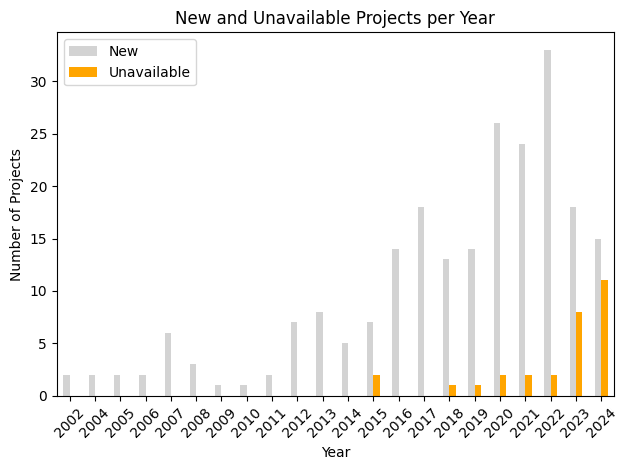

In [6]:
# Extract the year from the 'First_Seen' and 'Last_Seen' columns
data[KEY_URL_PROGETTO_FIRST_SEEN] = pd.to_datetime(data[KEY_URL_PROGETTO_FIRST_SEEN], errors='coerce')
data[KEY_URL_PROGETTO_LAST_SEEN] = pd.to_datetime(data[KEY_URL_PROGETTO_LAST_SEEN], errors='coerce')
data['Year_First_Seen'] = data[KEY_URL_PROGETTO_FIRST_SEEN].dt.year
data['Year_Last_Seen'] = data[KEY_URL_PROGETTO_LAST_SEEN].dt.year

# Calculate new projects
new_projects = data['Year_First_Seen'].value_counts().sort_index()

# Calculate unavailable projects
unavailable_projects = data[(data[KEY_URL_PROGETTO_LAST_SEEN].notna()) & (data[SITO_FUNZIONANTE] == False)]['Year_Last_Seen'].value_counts().sort_index()

# Create a DataFrame for plotting
years = sorted(set(new_projects.index).union(set(unavailable_projects.index)))
new_counts = [new_projects.get(year, 0) for year in years]
unavailable_counts = [unavailable_projects.get(year, 0) for year in years]

df_years = pd.DataFrame({
  'Year': years,
  'New': new_counts,
  'Unavailable': unavailable_counts
})

# Convert 'Year' column to integer for better readability on x-axis
df_years['Year'] = df_years['Year'].astype(int)

# Plot the bar chart
fig, ax = plt.subplots()
df_years.plot(kind='bar', x='Year', y=['New', 'Unavailable'], ax=ax, color=['lightgrey', 'orange'])
ax.set_title('New and Unavailable Projects per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Projects')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


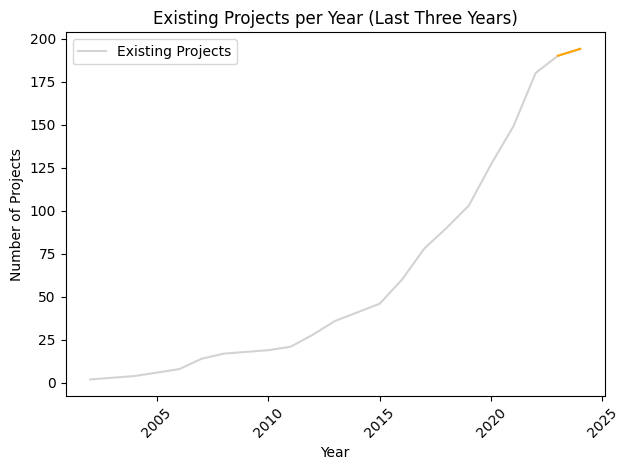

In [7]:
# Plot the line graph for existing projects per year
df_years['Existing'] = df_years.apply(lambda row: row['New'] - row['Unavailable'], axis=1).cumsum()

fig, ax = plt.subplots()
ax.plot(df_years['Year'], df_years['Existing'], label='Existing Projects', color='lightgrey')

# Highlight the last three years
highlight_years = df_years.tail(2)
ax.plot(highlight_years['Year'], highlight_years['Existing'], color='orange')

ax.set_title('Existing Projects per Year (Last Three Years)')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Projects')
ax.yaxis.get_major_locator().set_params(integer=True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

In [8]:
unavailable_projects = data[(data[SITO_NON_TROVATO] == False) & (data[SITO_FUNZIONANTE] == False)].copy()
unavailable_projects.loc[:, 'Years_Existing'] = unavailable_projects.apply(
  lambda row: row['Year_Last_Seen'] - row['Year_First_Seen'] if pd.notna(row['Year_Last_Seen']) and pd.notna(row['Year_First_Seen']) else None, axis=1)

# Convert years to months
unavailable_projects.loc[:, 'Months_Existing'] = unavailable_projects['Years_Existing'] * 12
# Calculate the average months of availability
average_months_existing = unavailable_projects['Months_Existing'].dropna().mean()

# Convert average months to years and months
average_years_existing = average_months_existing // 12
average_remaining_months_existing = average_months_existing % 12

print(f"Average availability of currently unavailable projects: {average_years_existing:.0f} years and {average_remaining_months_existing:.0f} months")

Average availability of currently unavailable projects: 3 years and 9 months


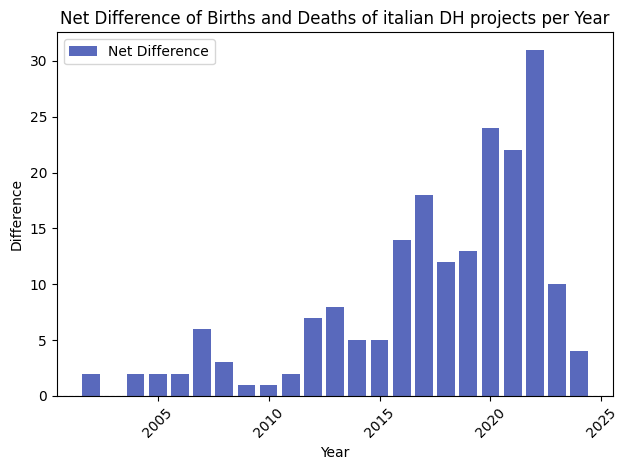


Table: Net Difference of Births and Deaths per Year
    Year  New  Unavailable  Net_Difference
0   2002    2            0               2
1   2004    2            0               2
2   2005    2            0               2
3   2006    2            0               2
4   2007    6            0               6
5   2008    3            0               3
6   2009    1            0               1
7   2010    1            0               1
8   2011    2            0               2
9   2012    7            0               7
10  2013    8            0               8
11  2014    5            0               5
12  2015    7            2               5
13  2016   14            0              14
14  2017   18            0              18
15  2018   13            1              12
16  2019   14            1              13
17  2020   26            2              24
18  2021   24            2              22
19  2022   33            2              31
20  2023   18            8              10
2

In [ ]:
# Calculate the net difference (births - deaths) per year
df_years['Net_Difference'] = df_years.apply(
    lambda row: row['New'] - row['Unavailable'], axis=1
)

# Plot the net difference as a bar chart
fig, ax = plt.subplots()
ax.bar(df_years['Year'], df_years['Net_Difference'], color='#5969bc', label='Net Difference')

ax.set_title('Net Difference of Births and Deaths of italian DH projects per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Difference')
plt.xticks(rotation=45)
ax.axhline(0, color='grey', linewidth=0.8, linestyle='--')  # Add a horizontal line at 0 for reference
plt.legend()
plt.tight_layout()

plt.show()

# Display the table with the Net Difference
df_difference_table = df_years[['Year', 'New', 'Unavailable', 'Net_Difference']].copy()
print("\nTable: Net Difference of Births and Deaths per Year")
print(df_difference_table)

# Optionally, save the table to a CSV file
difference_table_path = os.path.join(dir_path, "net_difference.csv")
df_difference_table.to_csv(difference_table_path, index=False)
print(f"\nTable saved")

